In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [67]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [68]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# predictor = SamPredictor(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [70]:
import xml.etree.ElementTree as ET
import glob
import shutil
import pandas as pd
import math
import os

df = pd.DataFrame()
xml_paths = glob.glob(r"C:\Users\bhusvis\OneDrive - Baker Hughes\Vishwa_files\LM2500_Project\Codes\SAM\segment-anything\notebooks\images\batch_2\xmls\*.xml")
img_path = r"C:\Users\bhusvis\OneDrive - Baker Hughes\Vishwa_files\LM2500_Project\Codes\SAM\segment-anything\notebooks\images\batch_2\images"

images_list = list()
bbox_list = list()
for path in xml_paths:
    tree = ET.parse(path)
    root = tree.getroot()
    file_name = root.find('filename').text
    file_name_wo_ext = file_name.split('.')[0]
    width = root.find('size').find('width').text
    height = root.find('size').find('height').text
    
    img = cv2.imread(os.path.join(img_path,file_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    images_list.append(img)
    # plt.imshow(img)
    
    bboxes = list()
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmin = int(float(obj.find('bndbox').find('xmin').text))
        ymin = int(float(obj.find('bndbox').find('ymin').text))
        xmax = int(float(obj.find('bndbox').find('xmax').text))
        ymax = int(float(obj.find('bndbox').find('ymax').text))
        # print(xmin,ymin,xmax,ymax)
        bbox = [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)

    bbox_tensor = torch.tensor(bboxes,device=sam.device)
    bbox_list.append(bbox_tensor)

In [71]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [72]:
batched_input = list()

for i,img in enumerate(images_list):
    temp_dict = {}
    temp_dict['image'] = prepare_image(img, resize_transform, sam)
    temp_dict['boxes'] = resize_transform.apply_boxes_torch(bbox_list[i], img.shape[:2])
    temp_dict['original_size'] = img.shape[:2]
    batched_input.append(temp_dict)


In [73]:
batched_output = sam(batched_input, multimask_output=False)

In [75]:
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

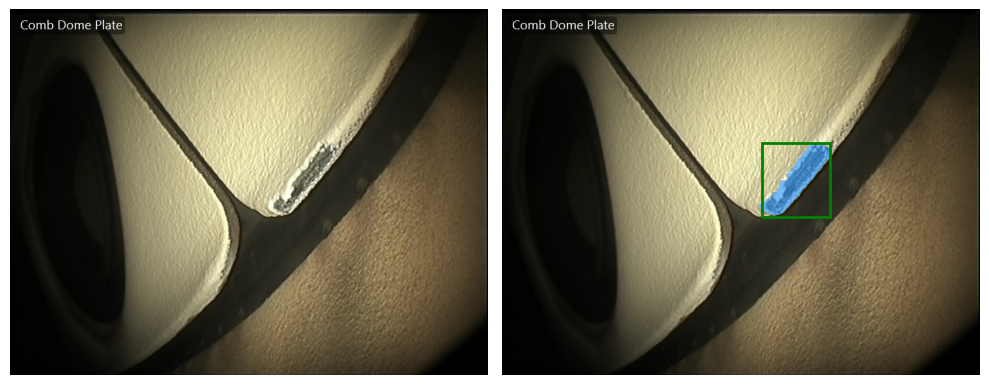

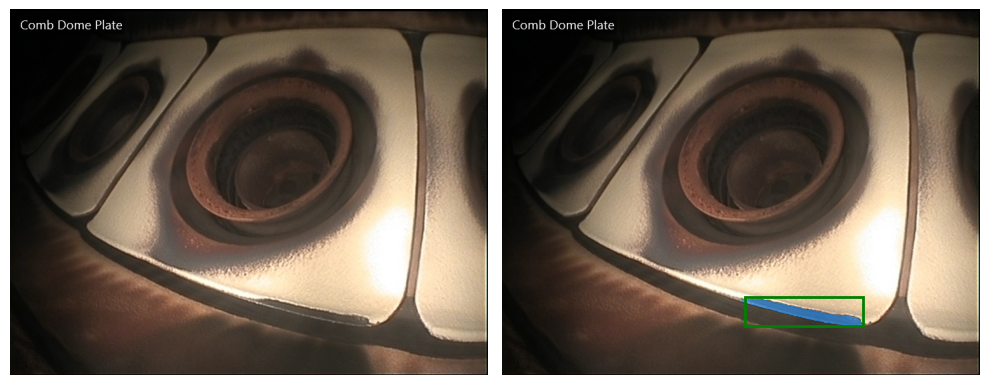

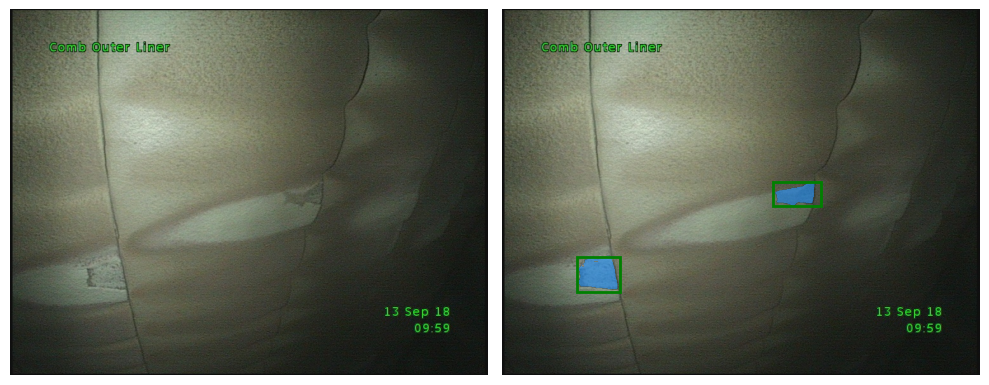

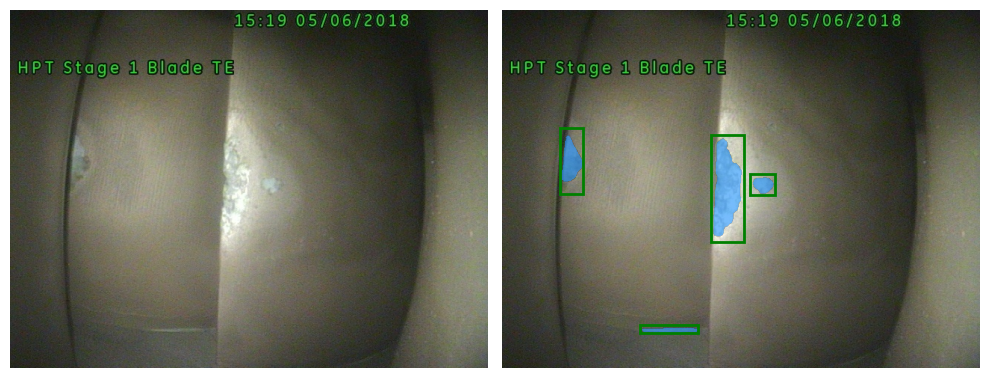

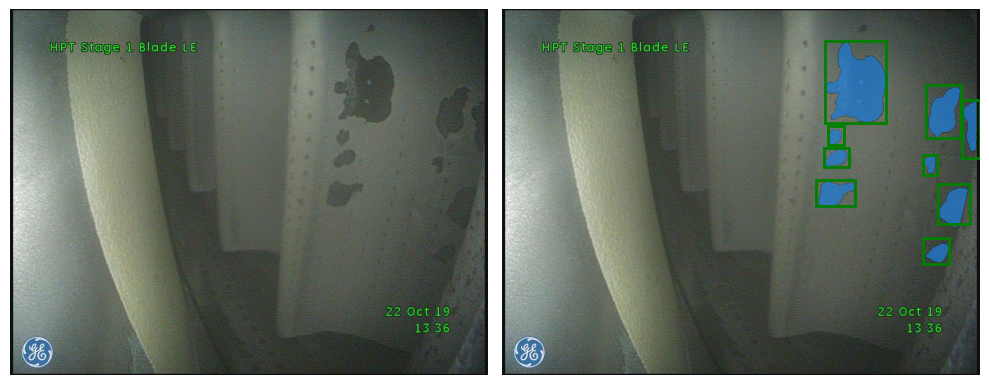

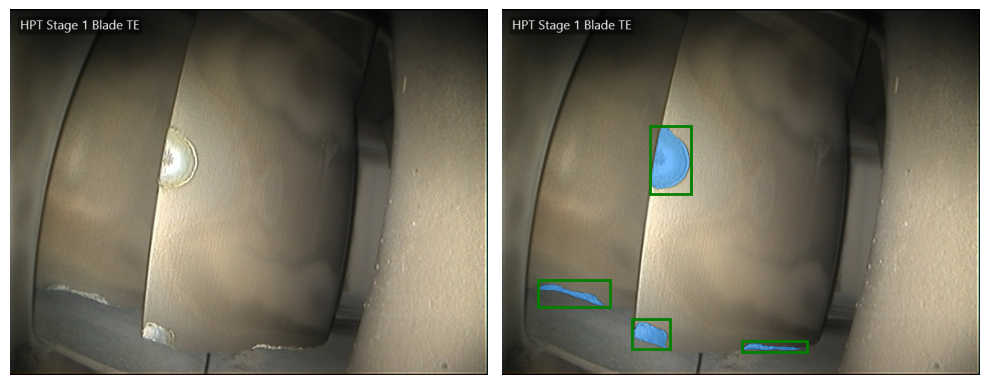

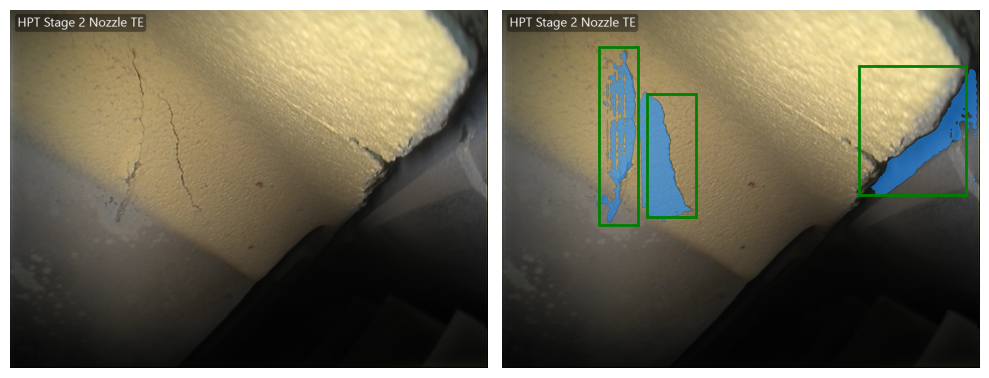

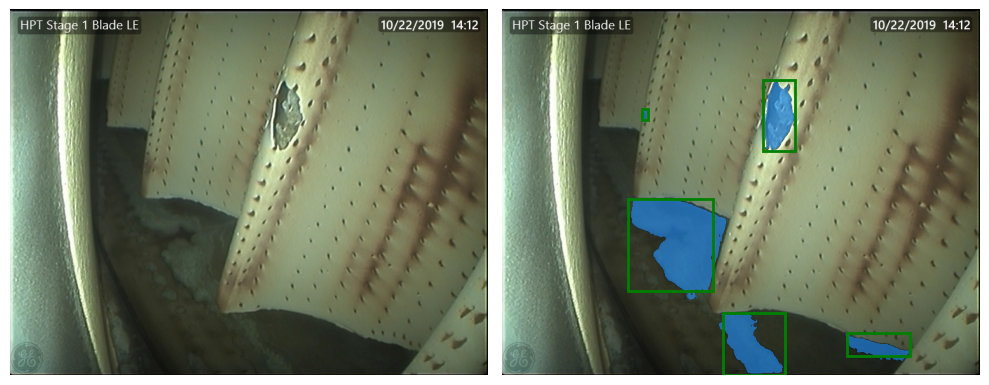

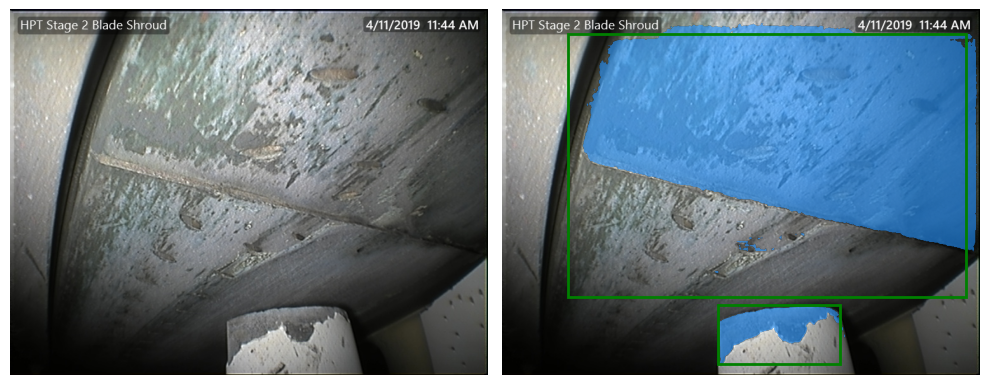

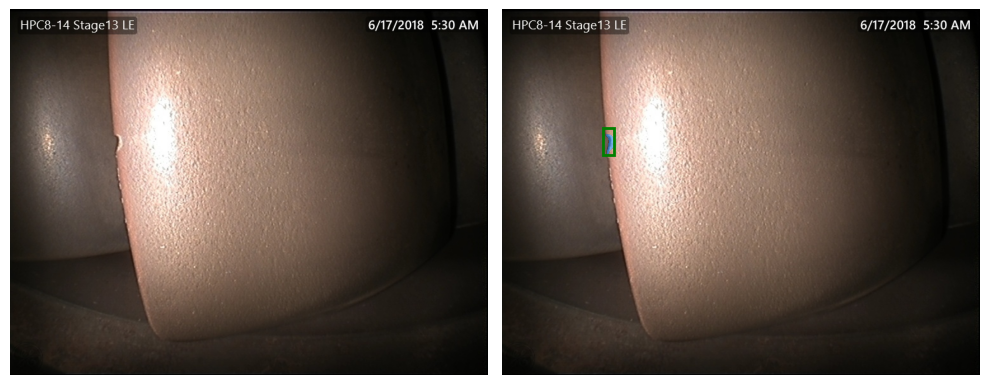

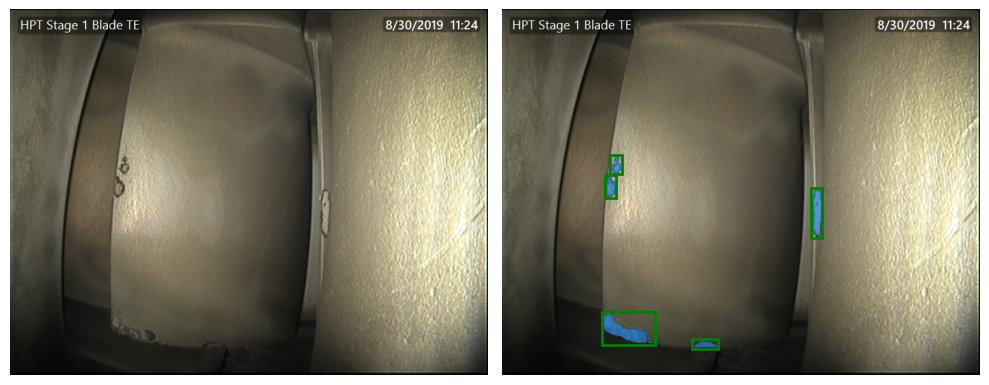

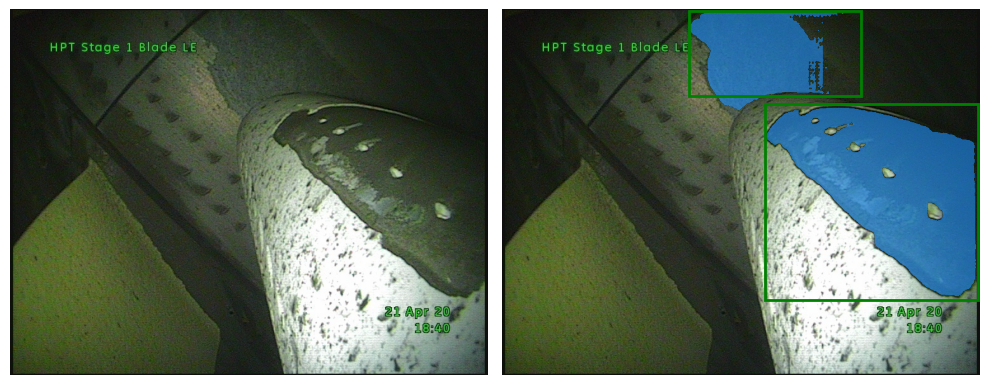

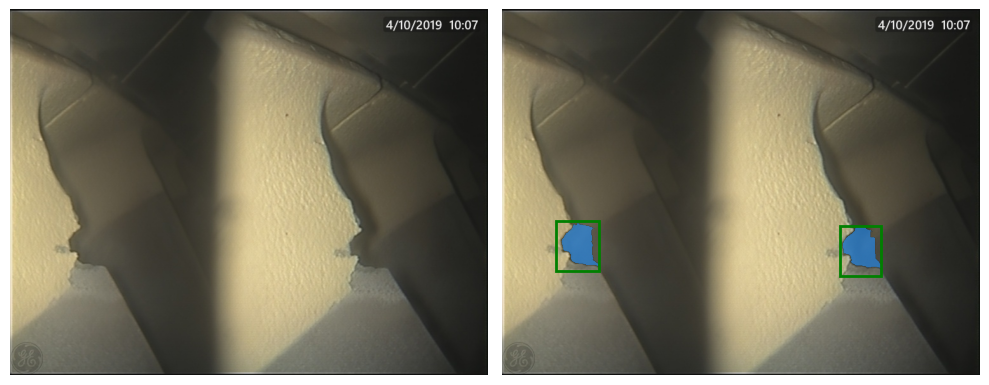

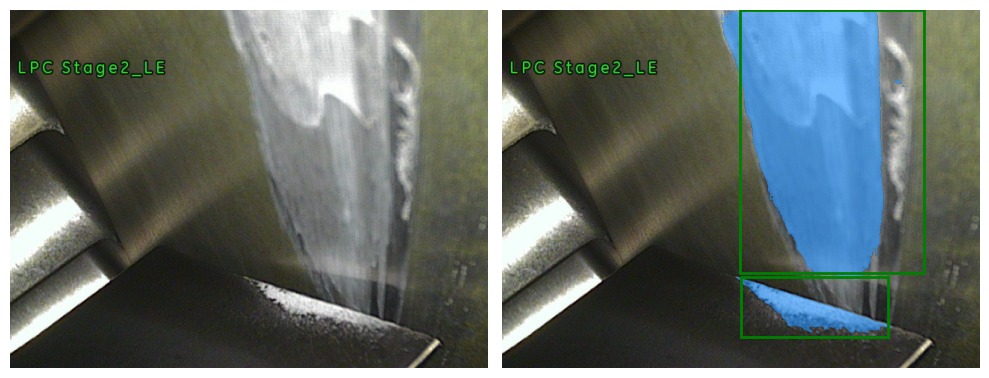

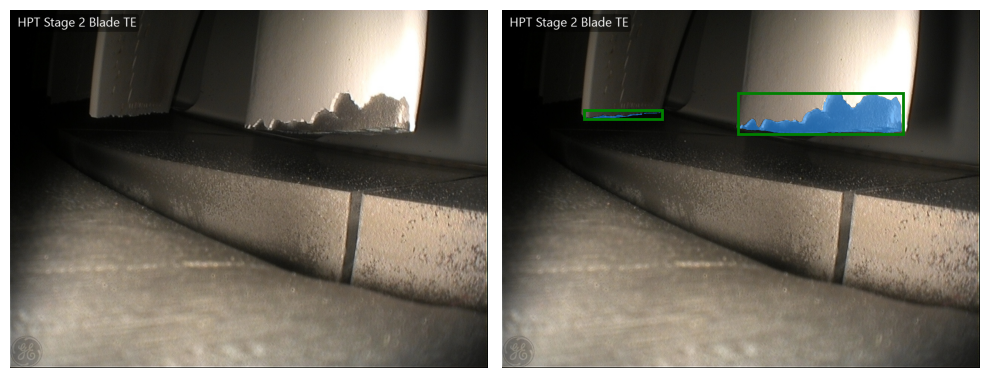

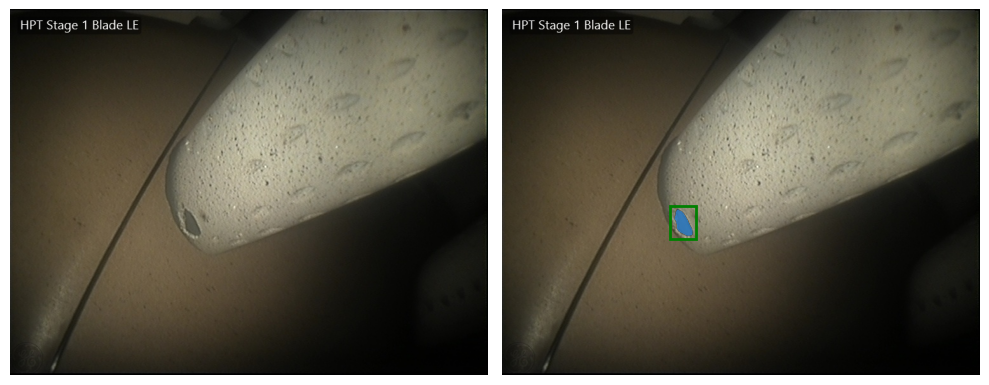

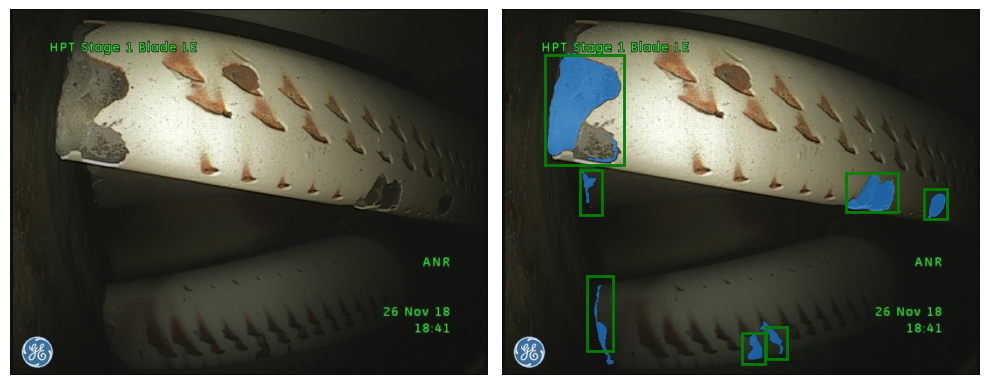

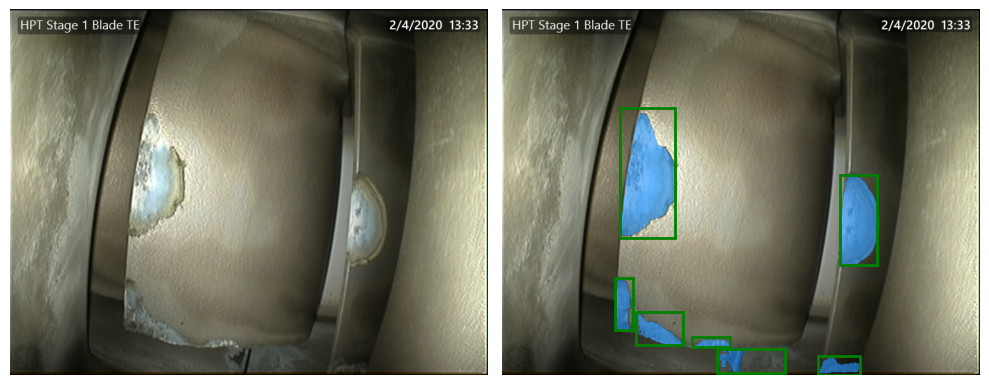

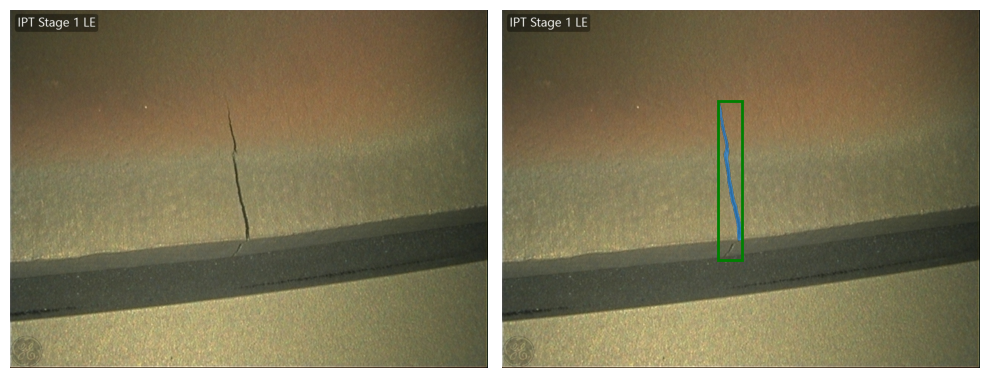

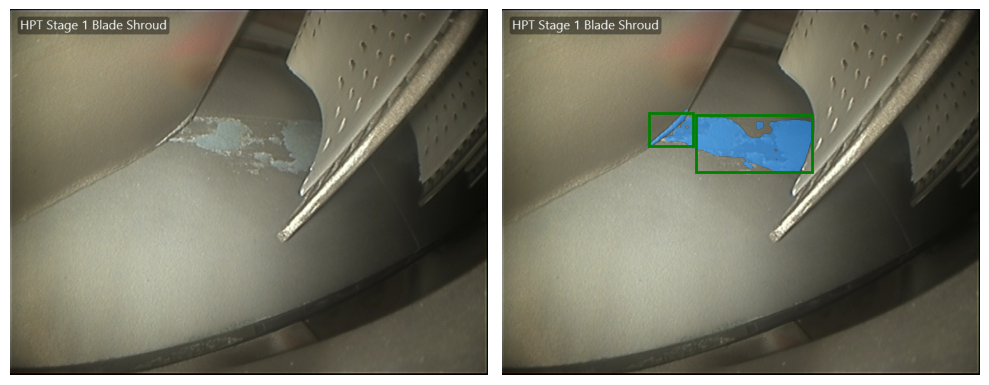

In [76]:

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("SAM_output_20.pdf")


for i in range(len(images_list)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(images_list[i])
    ax[0].axis('off')

    ax[1].imshow(images_list[i])
    for mask in batched_output[i]['masks']:
        show_mask(mask.cpu().numpy(), ax[1])
    for box in bbox_list[i]:
        show_box(box.cpu().numpy(), ax[1])
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'Outputs_2/output_{i}.jpg')
    pdf.savefig(fig)
    # plt.show()
pdf.close()

In [77]:
fig.number

20